## **import libraries**

In [64]:
import numpy as np # for calculation
import matplotlib.pyplot as plt # for plotting and viewing
import os # for loading images
from PIL import Image # for loading images 
import tensorflow as tf # model libraries
from tensorflow.keras.applications import MobileNetV2 # the main model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D # for building our layer
from tensorflow.keras.models import Model # for combining our layer and the model into a new model
from tensorflow.keras.preprocessing.image import ImageDataGenerator # for data process, It can be used for rescaling, data augmentation and splitting.
from tensorflow.keras.preprocessing import image # for load images

## **Data Process**

### (2.1) cretae a train data generator

In [12]:
# data normalization and augmenation
train_generator = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values to the range [0, 1]
    rotation_range=45,       # Randomly rotate images by up to 45 degrees
    width_shift_range=0.2,   # Randomly shift images horizontally by 20% of the width
    height_shift_range=0.2,  # Randomly shift images vertically by 20% of the height
    horizontal_flip=True,    # Randomly flip images horizontally
    validation_split=0.2     # Reserve 20% of the data for validation
)

### (2.2) Generate Train dataset

In [56]:
train_data = train_generator.flow_from_directory(
    'C:/Users/yangq/OneDrive/Desktop/computer vision/archive (1)/train',       # Path to the dataset directory
    target_size=(224, 224),  # Resize all images to 224x224 (required by most pre-trained models)
    batch_size=32,           # Process 32 images at a time (batch size)
    class_mode='categorical',# Labels are one-hot encoded (e.g., for 2 classes: [1, 0] and [0, 1])
    subset='training'        # Use the training subset (80% of data)
)

Found 447 images belonging to 2 classes.


### (2.3) Generate the Vaildation Dataset

### validation dataset is used to evaluate the model's performance after each epoch.
### It helps monitor whether the model is overfitting or improving generalization.

In [60]:
validation_data = train_generator.flow_from_directory(
    'C:/Users/yangq/OneDrive/Desktop/computer vision/archive (1)/train',       # Path to the dataset directory
    target_size=(224, 224),  # Resize all images to 224x224
    batch_size=32,           # Process 32 images at a time
    class_mode='categorical',# Labels are one-hot encoded
    subset='validation'      # Use the validation subset (20% of data)
)

Found 110 images belonging to 2 classes.


## **load Pretrained model**

In [34]:
base_pretrain_model = MobileNetV2(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')
base_pretrain_model.trainable = False # Freeze the base model layers initially

## **Build our layer and combine the base mobileNet2V model**

In [43]:
L = base_pretrain_model.output
L = GlobalAveragePooling2D()(L)  # Flatten the feature maps
L = Dense(128, activation='relu')(L)  # Add a dense layer
output = Dense(2, activation='softmax')(L)  # 2 classes (cats and dogs)

# Combine the base model and custom head
model = Model(inputs=base_pretrain_model.input, outputs=output)

In [50]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [52]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## **Train the model**

### Train the layer we have built first

In [70]:
model_train = model.fit(
    train_data,
    epochs=10,
    validation_data=validation_data
)

Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9908 - loss: 0.0448 - val_accuracy: 0.9273 - val_loss: 0.1352
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9857 - loss: 0.0445 - val_accuracy: 0.9273 - val_loss: 0.2319
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9715 - loss: 0.0595 - val_accuracy: 0.9364 - val_loss: 0.2130
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 995ms/step - accuracy: 0.9927 - loss: 0.0243 - val_accuracy: 0.9455 - val_loss: 0.2171
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9800 - loss: 0.0609 - val_accuracy: 0.9364 - val_loss: 0.1795
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9742 - loss: 0.0537 - val_accuracy: 0.9364 - val_loss: 0.1667
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9840 - loss: 0.0534 - val_accuracy: 0.9545 - val_loss: 0.1203
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9813 - loss: 0.0563 - val_accuracy: 0.9364 - val_lo

## **Fine Tune our whole model**

### Train the whole model

In [74]:
base_pretrain_model.trainable = True # Unfreeze the base model layers

# Compile the model with a low learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
model_train = model.fit(
    train_data,
    epochs=5,
    validation_data=validation_data
)

Epoch 1/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.8948 - loss: 0.2653 - val_accuracy: 0.9182 - val_loss: 0.2698
Epoch 2/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.9473 - loss: 0.1345 - val_accuracy: 0.9545 - val_loss: 0.1771
Epoch 3/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.9865 - loss: 0.0427 - val_accuracy: 0.9000 - val_loss: 0.1906
Epoch 4/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.9860 - loss: 0.0350 - val_accuracy: 0.9364 - val_loss: 0.1497
Epoch 5/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.9884 - loss: 0.0335 - val_accuracy: 0.9273 - val_loss: 0.1411


## **Save and reload the Model**

In [79]:
# HDF5 (Hierarchical Data Format 5) format
model.save('mobilenetv2_cats_dogs.h5')

# load the model
loaded_model = tf.keras.models.load_model('mobilenetv2_cats_dogs.h5')

## **Make Predictions**

## (8.1) Load Test images

In [101]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

In [107]:
# Path to the directory containing test images
test_path = 'C:/Users/yangq/OneDrive/Desktop/computer vision/archive (1)/test'

# List to store preprocessed images and their labels
image_list = []
image_names = []
image_classes = []

# Loop through each subfolder (e.g., 'cats', 'dogs')
for subfolder in os.listdir(test_path):
    subfolder_path = os.path.join(test_path, subfolder)

    # Check if it's a directory
    if os.path.isdir(subfolder_path):
        # Loop through each image in the subfolder
        for file_name in os.listdir(subfolder_path):
            file_path = os.path.join(subfolder_path, file_name)
            # Load and preprocess the image
            img_test = load_img(file_path, target_size=(224, 224))  # Resize to 224x224
            img_array_test = img_to_array(img_test)  # Convert to array
            img_array_test = img_array_test / 255.0  # Normalize pixel values
            img_array_test = np.expand_dims(img_array_test, axis=0)  # Add batch dimension

            # Store the image and its class
            image_list.append(img_array_test)
            image_names.append(file_name)
            image_classes.append(subfolder)  # Store the folder name as the class

### Combine all images into one Numpy Array

In [110]:
# Stack all images into a batch
if len(image_list) > 0:
    image_batch = np.vstack(image_list)  # Combine all images into one batch
    print(f"Processed {len(image_list)} images.")

Processed 140 images.


### (8.2) Make Predictions

In [115]:
predictions = model.predict(image_batch)

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 481ms/step


In [117]:
# Print predictions for each image
for i, prediction in enumerate(predictions):
    predicted_class = np.argmax(prediction)  # Get the index of the highest probability
    print(f"Image: {image_names[i]} - True Class: {image_classes[i]} - Predicted Class: {predicted_class}")

Image: cat_1.jpg - True Class: cats - Predicted Class: 0
Image: cat_106.jpg - True Class: cats - Predicted Class: 0
Image: cat_109.jpg - True Class: cats - Predicted Class: 0
Image: cat_113.jpg - True Class: cats - Predicted Class: 1
Image: cat_114.jpg - True Class: cats - Predicted Class: 0
Image: cat_116.jpg - True Class: cats - Predicted Class: 0
Image: cat_118.jpg - True Class: cats - Predicted Class: 0
Image: cat_119.jpg - True Class: cats - Predicted Class: 0
Image: cat_124.jpg - True Class: cats - Predicted Class: 0
Image: cat_140.jpg - True Class: cats - Predicted Class: 0
Image: cat_147.jpg - True Class: cats - Predicted Class: 0
Image: cat_156.jpg - True Class: cats - Predicted Class: 0
Image: cat_158.jpg - True Class: cats - Predicted Class: 0
Image: cat_162.jpg - True Class: cats - Predicted Class: 0
Image: cat_18.jpg - True Class: cats - Predicted Class: 0
Image: cat_190.jpg - True Class: cats - Predicted Class: 0
Image: cat_203.jpg - True Class: cats - Predicted Class: 0


## **Evaluate the Model**

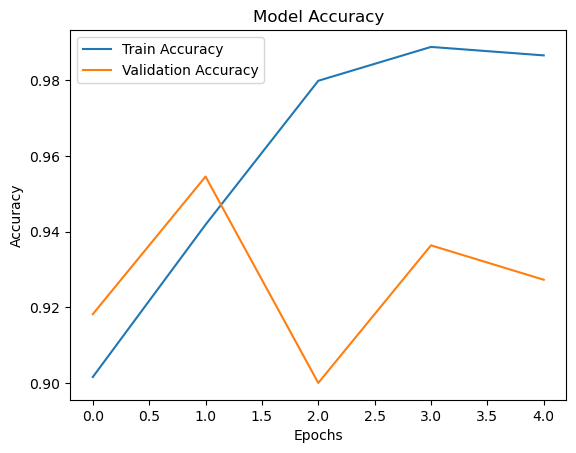

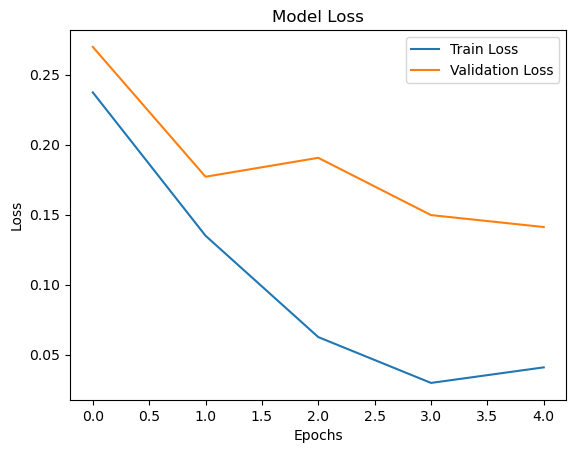

In [122]:
# Plot training & validation accuracy
plt.plot(model_train.history['accuracy'], label='Train Accuracy')
plt.plot(model_train.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(model_train.history['loss'], label='Train Loss')
plt.plot(model_train.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [128]:
# Example class labels (e.g., for binary classification)
class_labels = ['cats', 'dogs']

# Make predictions
predictions = model.predict(image_batch)

# Iterate through predictions and display results
for i, prediction in enumerate(predictions):
    predicted_index = np.argmax(prediction)  # Get the index of the highest probability
    predicted_label = class_labels[predicted_index]  # Map to class label
    confidence = prediction[predicted_index]  # Get the confidence score

    # Print the result
    print(f"Image: {image_names[i]}")
    print(f"Predicted Class: {predicted_label}")
    print(f"Confidence: {confidence:.2f}")
    print()

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step
Image: cat_1.jpg
Predicted Class: cats
Confidence: 1.00

Image: cat_106.jpg
Predicted Class: cats
Confidence: 1.00

Image: cat_109.jpg
Predicted Class: cats
Confidence: 1.00

Image: cat_113.jpg
Predicted Class: dogs
Confidence: 1.00

Image: cat_114.jpg
Predicted Class: cats
Confidence: 0.99

Image: cat_116.jpg
Predicted Class: cats
Confidence: 0.97

Image: cat_118.jpg
Predicted Class: cats
Confidence: 1.00

Image: cat_119.jpg
Predicted Class: cats
Confidence: 0.95

Image: cat_124.jpg
Predicted Class: cats
Confidence: 1.00

Image: cat_140.jpg
Predicted Class: cats
Confidence: 1.00

Image: cat_147.jpg
Predicted Class: cats
Confidence: 1.00

Image: cat_156.jpg
Predicted Class: cats
Confidence: 0.95

Image: cat_158.jpg
Predicted Class: cats
Confidence: 1.00

Image: cat_162.jpg
Predicted Class: cats
Confidence: 0.71

Image: cat_18.jpg
Predicted Class: cats
Confidence: 1.00

Image: cat_190.jpg
Predicted Class: cats
Confidence: 1.00

Image: cat_203.jpg
P

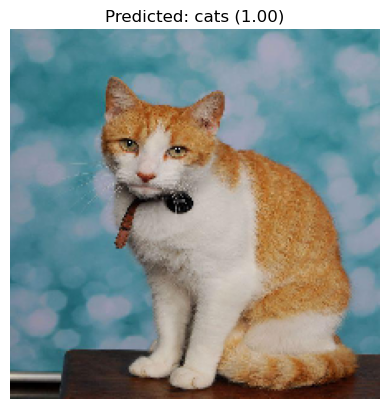

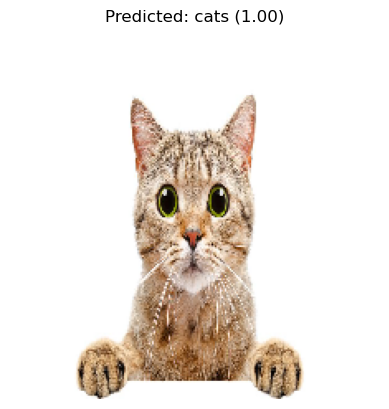

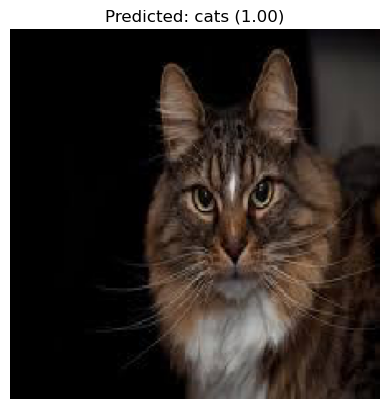

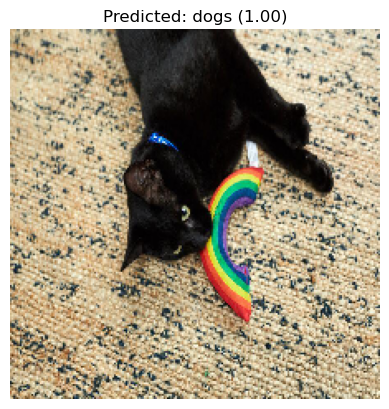

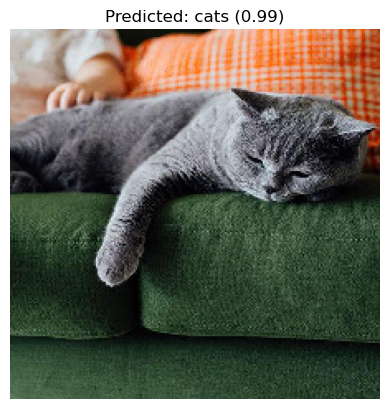

In [130]:
# Visualize the first few predictions
for i in range(len(image_batch[:5])):
    plt.imshow(image_batch[i])  # Display the image
    predicted_index = np.argmax(predictions[i])  # Get predicted class index
    predicted_label = class_labels[predicted_index]  # Map to class label
    confidence = predictions[i][predicted_index]  # Get confidence score

    plt.title(f"Predicted: {predicted_label} ({confidence:.2f})")
    plt.axis('off')
    plt.show()